# Adding income information to a synthetic population of households

In this example, we already have a synthetic population of households on Nantes city. This synthetic population was built using the French national Census of the population. For each household, serveral characteristics have been added:

- Ownership : owner or tenant of its accomodation
- Age : age of reference person
- Size : number of persons
- Family composition : composition (single person, couple with ou without children, etc)

The objectif is to add income information to each household. In order to reach this goal, we use another data source named Filosofi. More precisely, this data source gives information on the income distribution (deciles) for each city, per household characteristics.

Filosofi is an indicator set implemented by INSEE which is the French National Institute of Statistics. See [insee.fr](https://www.insee.fr/fr/metadonnees/source/serie/s1172) for more details.


In [1]:
import warnings
import pandas as pd
from bhepop2.max_entropy_enrich import MaxEntropyEnrichment
from bhepop2.tools import read_filosofi, compute_distribution, plot_analysis

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option("mode.chained_assignment", None)

## Data preparation

Read synthetic population which doesn't contain revenu information.

In [2]:
synth_pop = pd.read_csv("../data/inputs/nantes_synth_pop.csv", sep=";")

synth_pop.head()

,age,size,ownership,family_comp
0,60_74,2_pers,Owner,Couple_without_child
1,60_74,2_pers,Owner,Couple_without_child
2,60_74,2_pers,Owner,Couple_without_child
3,0_29,1_pers,Tenant,Single_wom
4,60_74,2_pers,Owner,Couple_without_child


Read Filosofi data and format dataframe.

In [3]:
filosofi = read_filosofi(
    "../data/raw/indic-struct-distrib-revenu-2015-COMMUNES/FILO_DISP_COM.xls", "15"
).query(f"commune_id == '44109'")

filosofi.rename(
    columns={
        "q1": "D1",
        "q2": "D2",
        "q3": "D3",
        "q4": "D4",
        "q5": "D5",
        "q6": "D6",
        "q7": "D7",
        "q8": "D8",
        "q9": "D9",
    },
    inplace=True,
)

filosofi.head()

,commune_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,reference_median,attribute,modality
14824,44109,10303.478261,13336.071429,16023.846154,18631.333333,21262.666667,24188.000000,27774.444444,32620.000000,41308.000000,21262.666667,all,all
1974,44109,9794.000000,12961.000000,14914.000000,16865.000000,18687.000000,20763.000000,23357.000000,27069.000000,33514.000000,18687.000000,size,1_pers
2144,44109,12176.000000,15552.666667,18356.000000,20919.333333,23434.666667,26330.666667,30140.000000,35136.000000,44134.000000,23434.666667,size,2_pers
2144,44109,10583.500000,13655.555556,16489.000000,19145.000000,21893.333333,24890.555556,28440.000000,33432.222222,42079.444444,21893.333333,size,3_pers
2144,44109,10740.476190,14130.000000,17206.666667,20138.095238,22955.238095,26148.000000,29644.000000,34238.000000,42998.095238,22955.238095,size,4_pers


## Run algorithm

In [4]:
# Household modalities
MODALITIES = {
    "ownership": ["Owner", "Tenant"],
    "age": ["0_29", "30_39", "40_49", "50_59", "60_74", "75_or_more"],
    "size": ["1_pers", "2_pers", "3_pers", "4_pers", "5_pers_or_more"],
    "family_comp": [
        "Single_man",
        "Single_wom",
        "Couple_without_child",
        "Couple_with_child",
        "Single_parent",
        "complex_hh",
    ],
}

# Algorithm parameters
PARAMETERS = {
    "abs_minimum": 0,
    "relative_maximum": 1.5,
    "maxentropy_algorithm": "Nelder-Mead",
    "maxentropy_verbose": 0,
    "delta_min": 1000,
}

# Optimisation preparation
enrich_class = MaxEntropyEnrichment(
    synth_pop, filosofi, list(MODALITIES.keys()), parameters=PARAMETERS, seed=42
)

# Run optimisation
enrich_class.optimise()

# Assign data to synthetic population
pop = enrich_class.assign_feature_value_to_pop()

pop.head()

,age,size,ownership,family_comp,feature
0,60_74,2_pers,Owner,Couple_without_child,33265.461538
1,60_74,2_pers,Owner,Couple_without_child,20221.600000
2,60_74,2_pers,Owner,Couple_without_child,36740.857143
3,0_29,1_pers,Tenant,Single_wom,28545.000000
4,60_74,2_pers,Owner,Couple_without_child,24924.555556


## Results analysis

### Data preparation

Format Filosofi data for comparison.

In [5]:
filosofi_formated = filosofi.copy()
del filosofi_formated["commune_id"]
del filosofi_formated["reference_median"]

filosofi_formated = filosofi_formated.melt(
    id_vars=["attribute", "modality"],
    value_vars=["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9"],
    value_name="feature",
    var_name="decile",
)
filosofi_formated["source"] = "Filosofi"

Format simulation data for comparison.

In [6]:
# distribution of all households
df_analysis = compute_distribution(pop)
df_analysis["attribute"] = "all"
df_analysis["modality"] = "all"

# distribution of each modality
for attribute in MODALITIES.keys():
    for modality in MODALITIES[attribute]:
        distribution = compute_distribution(pop[pop[attribute] == modality])
        distribution["attribute"] = attribute
        distribution["modality"] = modality

        df_analysis = pd.concat([df_analysis, distribution])

df_analysis["source"] = "bhepop2"

Merge observed Filosofi and simulation data.

In [7]:
# add filosofi data
df_analysis = pd.concat([df_analysis, filosofi_formated])

# format data
df_analysis = df_analysis.pivot(
    columns="source", index=["attribute", "modality", "decile"]
).reset_index()
df_analysis.columns = ["attribute", "modality", "decile", "Filosofi", "bhepop2"]

### Some plots

In [8]:
from IPython.display import Image

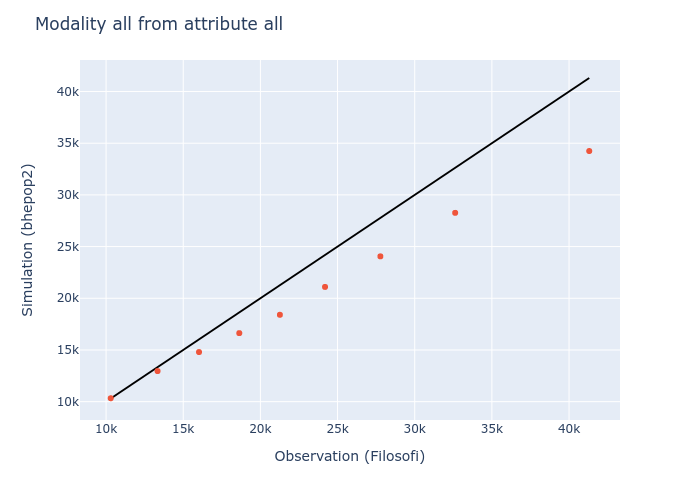

In [9]:
Image(plot_analysis(df_analysis, "all", "all").to_image())

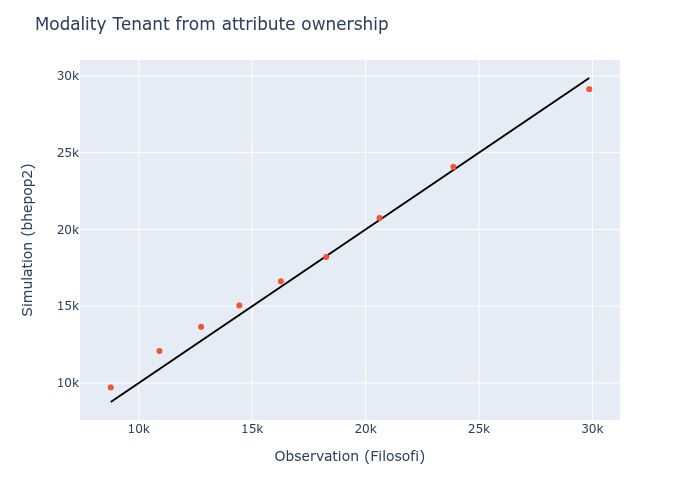

In [10]:
Image(plot_analysis(df_analysis, "ownership", "Tenant").to_image())

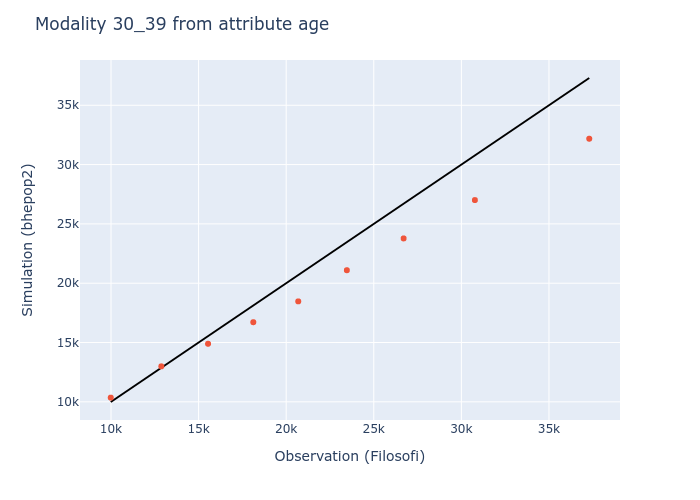

In [11]:
Image(plot_analysis(df_analysis, "age", "30_39").to_image())

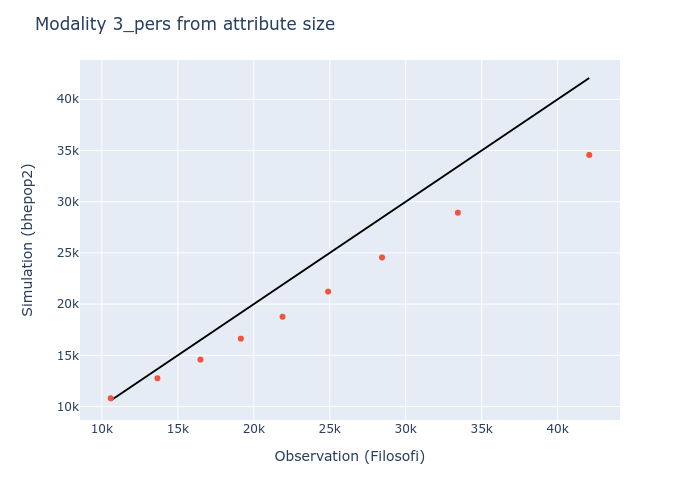

In [12]:
Image(plot_analysis(df_analysis, "size", "3_pers").to_image())

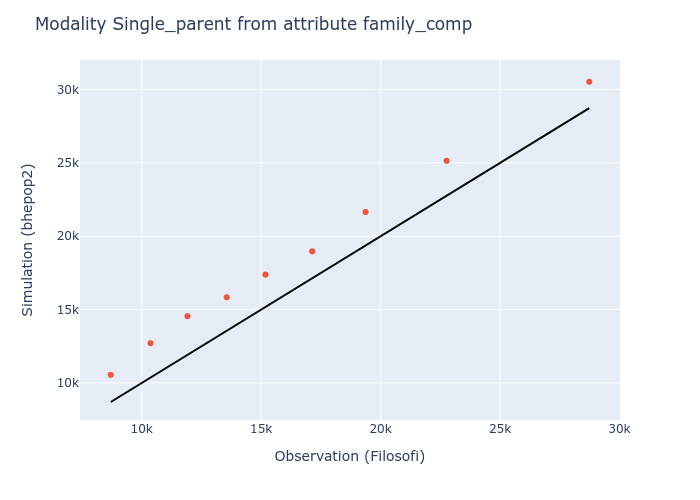

In [13]:
Image(plot_analysis(df_analysis, "family_comp", "Single_parent").to_image())